In [3]:
from bs4 import BeautifulSoup
import requests
import pymongo
import requests
from splinter import Browser
from selenium import webdriver
import pandas as pd
import time


In [2]:
!which chromedriver

/usr/local/bin/chromedriver


In [3]:
executable_path = {'executable_path': '/usr/local/bin/chromedriver'}
browser = Browser('chrome', **executable_path, headless=False)

In [4]:
conn = 'mongodb://localhost:27017'
client = pymongo.MongoClient(conn)

In [5]:
db = client.testdb
tripadvisor = db.tripadvisor
yelp = db.yelp

In [41]:
url = 'https://www.tripadvisor.com/Restaurant_Review-g28970-d622172-Reviews-Blue_Duck_Tavern-Washington_DC_District_of_Columbia.html'
browser.visit(url)

In [ ]:
# session = requests.Session()
# session.headers.update({'User-Agent': 'Custom user agent'})
# html = session.get(url)

In [42]:
html = browser.html
soup = BeautifulSoup(html, 'html.parser')
pages = soup.find('div', class_='pageNumbers')
number_of_pages = int(pages.find_all('a', class_='pageNum')[-1].text)

In [33]:
number_of_pages

190

**Tripadvisor**

In [43]:
ids = []
for p in range(1, number_of_pages):
    
    # open all closed links at first
    collapse = browser.find_by_css('span[class="taLnk ulBlueLinks"]')

    print(f'length of collapse is: {len(collapse)}')
    collapse.click()
    print('clicked')
    time.sleep(2)
    
    html = browser.html
    soup = BeautifulSoup(html, 'html.parser')
    revs = soup.find_all('div', class_='review-container')
    
    

    for r in revs:
        
        id = r.find('div', class_='reviewSelector')['data-reviewid']
        if id in ids:
            break
        
        
        title = r.find('span', class_='noQuotes').text
        date = r.find('span', class_='ratingDate relativeDate')['title']
        date = pd.to_datetime(date) #check if it works
        name = r.find('div', class_='username mo').text
        rating = int(r.find('div', class_='rating reviewItemInline').find('span')['class'][1][7:8])
        text = r.find('div', class_='entry').text
#         print(text)
        
        try:
            loc = r.find('span', class_='expand_inline userLocation')
            if loc.text:
                location = loc.text
        except AttributeError:
            print('no location')

        review = {
            'id': id,
            'date': date,
            'title': title,
            'rating': rating,
            'text': text,
            'username': name
        }
    
        if (location):
            review['userlocation']= location
        else:
            review['userlocation']='no_location'
    
    
        print(f'page: {p}')
        #print(review)
        print('--------------------')
        
        ids.append(id)
        
        collection.insert_one(review)
    
        review = {}
        title = ''
        date = ''
        name = ''
        rating = ''
        text = ''
        location = ''
    
    browser.click_link_by_text('Next') 
    time.sleep(5)

length of collapse is: 6
clicked
service I have ever experienced in a high-end restaurant. The cuisine is very good too (top marks for the cold corn soup and beef rib, and as for the bone marrow and cherry cobbler... Wow !) but Tibor is the one who really made our (anniversary) evening special. Thank you, thank you, thank you. Our “beautiful friendship” with the Blue Duck Tavern continues stronger than ever.Show less
page: 1
--------------------
We had reservation for lunch ... the food was wonderful ... we did not invent much at the request ... grilled bone marrow (fantastic!) ... steak tartar ... duck and steak ... all very American and tasty. .. great wine list ... price ranged within reasonable (250 US $)Show less
page: 1
--------------------
Blue Duck is simply delicious. This i is not my first meal this visit but my family came back for brunch and dinner again because the food is always reliable and delicious.
page: 1
--------------------
Excellent, center of the bat American Cus

**Yelp**

In [6]:
browser = webdriver.Chrome('/usr/local/bin/chromedriver')
# browser.implicitly_wait(10)

In [7]:
browser.get('https://www.yelp.com/biz/blue-duck-tavern-washington')

In [8]:
number_of_pages = int(browser.find_element_by_class_name('page-of-pages').text.split()[-1])
number_of_pages

104

In [1]:
def getYelp(address):
    
    browser = webdriver.Chrome('/usr/local/bin/chromedriver')
    browser.implicitly_wait(10)
    browser.get(address)
    
    number_of_pages = int(browser.find_element_by_class_name('page-of-pages').text.split()[-1])
    
    ids = []

    for page in range(1, number_of_pages):

        print(page)

        html = browser.page_source
        soup = BeautifulSoup(html, 'html.parser')
        reviews = soup.find_all('div', class_='review--with-sidebar')
        reviews = reviews[1:]

        for review in reviews:

            id = review['data-review-id']
            if id in ids:
                    break

            date = pd.to_datetime(review.find('span', class_='rating-qualifier').text.split()[0])
            rating = (int(review.find('div', class_='rating-large')['title'].split()[0][0]))
            text = review.find('div', class_='review-content').find('p').text
            username = review.find('a', class_='user-display-name').text

            try:
                loc = review.find('li', class_='user-location')
                if loc.text:
                    city = loc.text.split(',')[0][1:]
                    state = loc.text.split(',')[1][1:-1]
            except AttributeError:
                print('no location')

            ids.append(id)

            review = {
                    'id': id,
                    'date': date,
                    'rating': rating,
                    'text': text,
                    'username': username,
                    'city': city,
                    'state': state
                }


            yelp.insert_one(review)

            review = {}
            title = ''
            date = ''
            name = ''
            rating = ''
            text = ''
            location = ''

        browser.find_element_by_class_name('next').click()
        time.sleep(2)
    
    browser.quit()
    
    

In [6]:
getYelp('https://www.yelp.com/biz/blue-duck-tavern-washington')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103


**Extracting, saving, plotting**

In [13]:
data = db.reviews.find()
df = pd.DataFrame(list(yelp.find()))
# df['date'] = pd.to_datetime(df['date'])
df.head()

,_id,city,date,id,rating,state,text,username
0,5b747dd74231c707b3dcf503,Potomac,2018-08-13,Seel-sjamYb5abykdfKeEg,5,MD,Blue Duck Tavern was such an incredible dining...,Tessa A.
1,5b747dd74231c707b3dcf504,Alexandria,2018-08-12,NVIECLsei3XESiliyghhSA,5,VA,"With a Michelin Star, it's no surprise that Bl...",Michelle P.
2,5b747dd74231c707b3dcf505,Washington,2018-08-12,xQQ7Qyozdpmm_uBJytWeFQ,5,DC,Five stars for an excellent brunch with fantas...,Heather P.
3,5b747dd74231c707b3dcf506,New York,2018-06-22,7Zd8QrDDi4fkFqwanHfppQ,3,NY,We came for Father's day brunch. The restauran...,Lu H.
4,5b747dd74231c707b3dcf507,Arlington,2018-07-04,L3SdS-vlVM6V-w01csE6bg,4,VA,A very long overdue review -My boyfriend and I...,Vicky L.


In [13]:
df = df.drop('_id', 1)

In [14]:
df.to_csv('yelp.csv')

In [194]:
# pd.to_datetime(revs[5].find('span', class_='ratingDate relativeDate')['title'])

In [15]:
df.dtypes

city                object
date        datetime64[ns]
id                  object
rating               int64
state               object
text                object
username            object
dtype: object

In [75]:
# df['rating'] = pd.to_numeric(df['rating'])

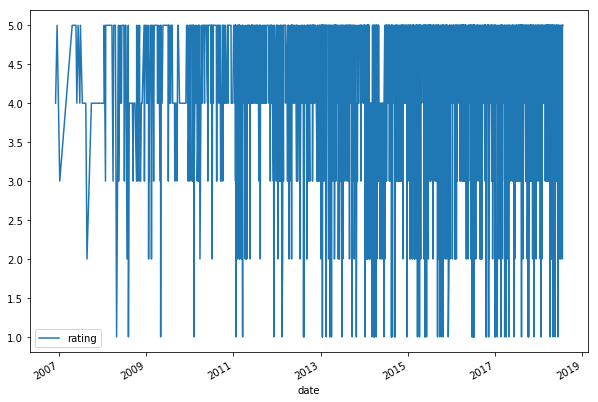

In [188]:
df.plot(x='date', y='rating', figsize=(10,7))

In [189]:
df.groupby(['rating', 'date'])

In [16]:
df1 = df.groupby(pd.Grouper(key='date', freq='1M')).mean()

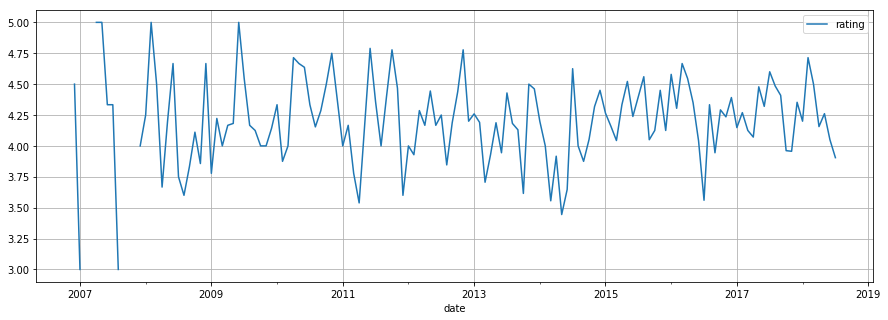

In [18]:
df1.plot(grid=True, figsize=(15,5))